<a href="https://colab.research.google.com/github/mrreyesm/SECOM/blob/main/SECOM_2_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SECOM: Data Preparation & Modelling

#GLOBAL VARIABLES

In [ ]:
test_size = .2
perc_missing_values = .55
variance_threshold = 0.995
corr_threshold = 0.99
n_features_rfe = 25

# Setting Environment

## Libraries

In [ ]:
#Importing Librarys 
# For system related operations
import sys
#For the creation of dataframes and manipulating data
import pandas as pd
from pandas.api.types import is_numeric_dtype
# For numerical processing
import numpy as np
# For statistical analysis
import statistics
# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Stats
from scipy.stats import shapiro
# Iterable tools
from itertools import combinations
import warnings
warnings.filterwarnings("ignore")
# For creating models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
!{sys.executable} -m pip install boruta
from boruta import BorutaPy
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Master functions

In [ ]:
# Create function that describes each column
def descriptive_statistics(df):
  #Creates empty target dataframe
  col_names = ["FEATURE", "COUNT", "SUM",  "MEAN", "MIN", "Q1", "MEDIAN",
             "Q3", "MAX", "VARIANCE", "STANDARD_DEV", "UNIQUE_VALUES",
             "MISSING_VALUES", "PERCENTAGE_NA", "OUTLIERS_3S", "PERCENTAGE_O3S",
             "NORM_STD"]
  descriptive_df = pd.DataFrame(columns=col_names)
  # Only for numeric values
  df = df.select_dtypes(include=['int64','float64'])
  # Iterates through each column
  for col, col_name in enumerate(df.columns):
    num_values = df[col_name].count()
    sum = df[col_name].sum()
    # Central tendency
    mean = df[col_name].mean()
    min = df[col_name].min()
    q1 = df[col_name].quantile(0.25)
    median = df[col_name].quantile(0.50)
    q3 = df[col_name].quantile(0.75)
    max = df[col_name].max()
    # Volatility
    var = df[col_name].var()
    std = df[col_name].std()
    unique = df[col_name].nunique()
    missing = df[col_name].isnull().sum()
    percentage_na = df[col_name].isnull().sum() * 100 / len(df[col_name])
    # Outlier identification with zscore
    zscores = (df[col_name]-mean)/std
    zscores = zscores.to_frame()
    zoutliers = zscores.query(f"{col_name} > 3 or {col_name} < -3")
    outliers = zoutliers[col_name].count()
    perc_out = (outliers/num_values)*100
    # Min - Max normalization
    temp = (df[col_name] - min)/ (max - min)
    std_norm_values = temp.std()
    # Creates a list wirh all the values and concatenates it to target df
    desc = [col_name, num_values, sum,  mean, min, q1, median, q3,
           max, var, std, unique, missing, percentage_na, outliers,
           perc_out, std_norm_values]
    df_length = len(descriptive_df)
    descriptive_df.loc[df_length] = desc
  return descriptive_df

In [ ]:
# Create function that counts columns with above certain % of NAs
def show_features_many_nulls(df, percentage):
    features_nulls = []
    for col in df.columns:
        percentage_nulls = 100 * (df[col].isna().sum() / len(df[col]))
        if (percentage_nulls > percentage) and (col != 'TIMESTAMP' or col != 'STATUS'):
          features_nulls.append(col)
    print(f"Features with more than {percentage}% of missing values, {len(features_nulls)}")

In [ ]:
#functions to treat outliers
def outlier_replacement(data):
  copy_train_df = data.copy()
  df = data.copy()
  for col in df.columns:
      mean = df[col].mean()
      std_dev = df[col].std(axis=0)
      copy_train_df[col] = np.where(df[col] > (mean + 3*std_dev), 1, np.where(df[col] < (mean - 3*std_dev), 1, 0))                            
      df[col] = np.where(df[col] > (mean + 3*std_dev) , (mean + 3*std_dev), np.where(df[col] < (mean - 3*std_dev) , (mean - 3*std_dev), df[col]))  
  print("TOTAL OF VALUES: ", (copy_train_df.isnull().sum().sum() + copy_train_df.notnull().sum().sum()),
        "\nTOTAL OF OUTLIERS: ", copy_train_df.sum().sum(),
        "\nPERCENTAGE OF OUTLIERS REPLACED: ", (copy_train_df.sum().sum()/(copy_train_df.isnull().sum().sum() + copy_train_df.notnull().sum().sum()))*100, "%"  )
  return df

In [ ]:
#function to apply kNN imputation
def knn_imputation(data):
  scaler = MinMaxScaler(feature_range=(-1,1))
  df = pd.DataFrame(scaler.fit_transform(data), columns = data.columns)
  print("PERCENTAGE OF MISSING VALUES:",
        round((df.isnull().sum().sum()/(df.isnull().sum().sum() 
        + df.notnull().sum().sum()))*100, 2) , " %\n")
  imputer = KNNImputer(n_neighbors=5)
  df = pd.DataFrame(imputer.fit_transform(df),columns = df.columns)
  print("PERCENTAGE OF MISSING VALUES AFTER IMPUTATION:",
        round((df.isnull().sum().sum()/(df.isnull().sum().sum() 
        + df.notnull().sum().sum()))*100, 2) , " %")
  return df

In [ ]:
#function to apply MICE imputation
def mice_imputation(data):
  print("PERCENTAGE OF MISSING VALUES:",
        round((data.isnull().sum().sum()/(data.isnull().sum().sum() 
        + data.notnull().sum().sum()))*100, 2) , " %")
  df = data.copy()
  lr = LinearRegression()
  mice_imputer = IterativeImputer(estimator=lr,missing_values=np.nan, max_iter=10, imputation_order='roman',random_state=42)
  df.iloc[:, :] = mice_imputer.fit_transform(data)
  print("PERCENTAGE OF MISSING VALUES AFTER MICE:",round((df.isnull().sum().sum()/(df.isnull().sum().sum() 
        + df.notnull().sum().sum()))*100, 2) , " %\n")
  return df

In [ ]:
#funciton to apply boruta feature selection
def boruta_feature_selection(data, target_var):
  data[target_var] = np.where(data[target_var] < 0, -1, 1)
  # define random forest classifier
  forest = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
  df = data.iloc[: , :-1]
  forest.fit(np.array(df), np.array(data[target_var]))
  # define Boruta feature selection method
  feat_selector = BorutaPy(forest, n_estimators='auto', random_state=42)
  # find all relevant features
  feat_selector.fit(np.array(df), np.array(data[target_var]))
  # zip my names, ranks, and decisions in a single iterable
  feature_ranks = list(zip(df.columns, 
                          feat_selector.ranking_, 
                          feat_selector.support_))
  feature_ranks = pd.DataFrame (feature_ranks, columns = ['FEATURE', 'RANK', 'KEEP'])
  boruta_features = feature_ranks.query("KEEP == True")
  boruta_features = boruta_features["FEATURE"].unique()
  boruta_features = np.append(boruta_features, target_var)
  df = data[boruta_features]
  print("FEATURES LEFT WITH BORUTA: ",df.shape[1], "\n")
  return df

In [ ]:
#funciton to apply RFE feature selection
def rfe_feature_selection(data, target_var, n_features):
  data[target_var] = np.where(data[target_var] < 0, -1, 1)
  # define random forest classifier
  forest = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
  df = data.iloc[: , :-1]
  forest.fit(np.array(df), np.array(data[target_var]))
  # define Boruta feature selection method
  feat_selector =RFE(forest, n_features_to_select = n_features)
  # find all relevant features
  feat_selector.fit(np.array(df), np.array(data[target_var]))
  # zip my names, ranks, and decisions in a single iterable
  feature_ranks = list(zip(df.columns, 
                          feat_selector.ranking_, 
                          feat_selector.support_))
  feature_ranks = pd.DataFrame (feature_ranks, columns = ['FEATURE', 'RANK', 'KEEP'])
  rfe_features = feature_ranks.query("KEEP == True")
  rfe_features = rfe_features["FEATURE"].unique()
  rfe_features = np.append(rfe_features, target_var)
  df = data[rfe_features]
  print("FEATURES LEFT WITH RFE: ",df.shape[1], "\n")
  return df

In [ ]:
#function to apply SMOTE balancing
def smote_balancing(data, target_var):
  print("BEFORE BALANCING")
  print(data.groupby([target_var]).size().reset_index().rename(columns={0:'count'}))
  smote = SMOTE(random_state=42)
  df = data.iloc[: , :-1]
  df_data_sm, df_target_sm = smote.fit_resample(df, data[target_var])
  print("AFTER SMOTE BALANCING")
  df = pd.concat([df_data_sm, df_target_sm], axis=1)
  print(df.groupby([target_var]).size().reset_index().rename(columns={0:'count'}))
  return df 

In [ ]:
#function to apply ROSE balancing
def rose_balancing(data, target_var):
  print("BEFORE BALANCING")
  print(data.groupby([target_var]).size().reset_index().rename(columns={0:'count'}))
  ros = RandomOverSampler(random_state=42)
  df = data.iloc[: , :-1]
  print("AFTER ROSE BALANCING")
  df_data_ros, df_target_ros = ros.fit_resample(df, data[target_var])
  df = pd.concat([df_data_ros, df_target_ros], axis=1)
  print(df.groupby([target_var]).size().reset_index().rename(columns={0:'count'}))
  return df

In [ ]:
def logistic_regression(X_train, X_test, target_var):
  Y_train = np.where(X_train[target_var] < 0, -1, 1)
  X_train = X_train.iloc[: , :-1]
  Y_test = np.where(X_test[target_var] < 0, -1, 1)
  X_test = X_test.iloc[: , :-1]
  logreg = LogisticRegression()
  logreg.fit(X_train, Y_train)
  Y_pred = logreg.predict(X_test)
  print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
  print(classification_report(Y_test, Y_pred))
  print('Average Accuracy:', accuracy_score(Y_test, Y_pred))
  logit_roc_auc = roc_auc_score(Y_test, logreg.predict(X_test))
  fpr, tpr, thresholds = roc_curve(Y_test, logreg.predict_proba(X_test)[:,1])
  plt.figure()
  plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  plt.savefig('Log_ROC')
  plt.show()

In [ ]:
def logistic_regression_with_scaler(X_train, X_test, target_var):
  scaler = MinMaxScaler(feature_range=(-1,1))
  Y_train = np.where(X_train[target_var] < 0, -1, 1)
  X_train = X_train.iloc[: , :-1]
  X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
  Y_test = np.where(X_test[target_var] < 0, -1, 1)
  X_test = X_test.iloc[: , :-1]
  X_test = pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns)
  logreg = LogisticRegression()
  logreg.fit(X_train, Y_train)
  Y_pred = logreg.predict(X_test)
  print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
  print(classification_report(Y_test, Y_pred))
  print('Average Accuracy:', accuracy_score(Y_test, Y_pred))
  logit_roc_auc = roc_auc_score(Y_test, logreg.predict(X_test))
  fpr, tpr, thresholds = roc_curve(Y_test, logreg.predict_proba(X_test)[:,1])
  plt.figure()
  plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  plt.savefig('Log_ROC')
  plt.show()

## Loading data

In [ ]:
# Creates a dataframe with the features of the SECOM dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data"
secom_features = pd.read_csv(url, sep = ' ', header = None)
# Gives names to the columns according to their position in the dataset
secom_features.columns = ["FEATURE_"+str(col+1) for col in
                          range(0,len(secom_features.columns))]
# Creates a dataframe with the labels of the SECOM dataset and gives a col name
url="https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data"
secom_labels = pd.read_csv(url, sep = " ", header = None)
secom_labels.columns = ("STATUS", "TIMESTAMP")
# Changes timestamp column to datetime format
secom_labels['TIMESTAMP'] =  pd.to_datetime(secom_labels['TIMESTAMP'])
# Merges both datasets through the index
secom_data = pd.merge(secom_labels, secom_features, left_index=True,
                      right_index=True)
secom_data.shape

(1567, 592)

# Splitting data

In [ ]:
# Subset dataset between fail and pass, split and then concatenate to keep proportion
subset = secom_data.drop(columns = "TIMESTAMP")
# select pass cases
pass_df = subset[subset["STATUS"] == 1]
X_p = pass_df.iloc[:,1:]
y_p = pass_df.loc[:,"STATUS"]
# select fail cases
fail_df = subset[subset["STATUS"] == -1]
X_f = fail_df.iloc[:,1:]
y_f = fail_df.loc[:,"STATUS"]
#Split into test and train dataset 80% 20%
X_train_p,X_test_p,y_train_p,y_test_p = train_test_split(X_p, y_p, test_size=test_size,
                                                         random_state=42)
X_train_f,X_test_f,y_train_f,y_test_f = train_test_split(X_f, y_f, test_size=test_size,
                                                         random_state=42)
#Concatenate results
X_train = pd.concat([X_train_p, X_train_f], axis=0)
X_test = pd.concat([X_test_p, X_test_f], axis=0)
y_train = pd.concat([y_train_p, y_train_f], axis=0)
y_test = pd.concat([y_test_p, y_test_f], axis=0)
#Examine proportions of train dataset
print("----TRAIN DATASET----\n")
X_train = pd.concat([X_train, y_train], axis=1)
print(X_train.shape)
Fail = X_train[X_train["STATUS"] == 1]
Pass = X_train[X_train["STATUS"] == -1]
print( "Fail cases: ", Fail["STATUS"].count(), "Pass cases: ", Pass["STATUS"].count())
# Overall number of missing values in the dataset
print("PERCENTAGE OF MISSING VALUES :",
      round((X_train.isnull().sum().sum()/(X_train.isnull().sum().sum() 
      + X_train.notnull().sum().sum()))*100, 2) , " %")
#Examine proportions of test dataset
print("\n----TEST DATASET----\n")
X_test = pd.concat([X_test, y_test], axis=1)
print(X_test.shape)
Fail = X_test[X_test["STATUS"] == 1]
Pass = X_test[X_test["STATUS"] == -1]
print( "Fail cases: ", Fail["STATUS"].count(), "Pass cases: ", Pass["STATUS"].count())
# Overall number of missing values in the dataset
print("PERCENTAGE OF MISSING VALUES :",
      round((X_test.isnull().sum().sum()/(X_test.isnull().sum().sum() 
      + X_test.notnull().sum().sum()))*100, 2) , " %")
show_features_many_nulls(X_test, 55)

----TRAIN DATASET----

(1253, 591)
Fail cases:  83 Pass cases:  1170
PERCENTAGE OF MISSING VALUES : 4.54  %

----TEST DATASET----

(314, 591)
Fail cases:  21 Pass cases:  293
PERCENTAGE OF MISSING VALUES : 4.49  %
Features with more than 55% of missing values, 24


#Reducing Dimensionality

## High Percentage of missing values

In [ ]:
#Copy the Dataset to easily go back if mistakes are made
X_train_df = X_train.copy()
#This code will remove the features with a High Percentage of missing values (more than 55%)
X_train_df_ = X_train_df
print("TOTAL FEATURES: ", len(X_train_df_.columns))
X_train_df = X_train_df.loc[:, X_train_df.isnull().mean() < perc_missing_values]
print("FEATURES REMOVED: ", len(X_train_df_.columns)-len(X_train_df.columns),f" cols with >{perc_missing_values*100}% Nulls"
      "\nFEATURES LEFT: ", len(X_train_df.columns))

TOTAL FEATURES:  591
FEATURES REMOVED:  24  cols with >55.00000000000001% Nulls
FEATURES LEFT:  567


## Low Variance

In [ ]:
X_train_dftemp = X_train_df
scaler = MinMaxScaler(feature_range=(-1,1))
X_train_df = pd.DataFrame(scaler.fit_transform(X_train_df), columns = X_train_df.columns)
threshold = variance_threshold
var_threshold = threshold * (1 - threshold)
varThreshold = VarianceThreshold(var_threshold)
varThreshold.fit(X_train_df)
mask = varThreshold.get_support()
low_var_features = X_train_df.loc[:, ~mask].columns
X_train_df.drop(low_var_features, axis=1, inplace=True)
print("TOTAL FEATURES: ", len(X_train_dftemp.columns),
      "\nFEATURES REMOVED: ", len(X_train_dftemp.columns)-len(X_train_df.columns), f" featueres with stdev = 0 or whose values are equal in more than {threshold*100}% of the feature",
      "\nFEATURES LEFT: ", len(X_train_df.columns), "\n")
features_descriptives = descriptive_statistics(X_train_df)
volatility = features_descriptives["NORM_STD"].where(features_descriptives["FEATURE"] != "STATUS")

TOTAL FEATURES:  567 
FEATURES REMOVED:  140  featueres with stdev = 0 or whose values are equal in more than 99.5% of the feature 
FEATURES LEFT:  427 



## High Correlation
Remove highly correlated features that have low correlation with target.

In [ ]:
corr_df = pd.DataFrame(columns=["FEATURE_A", "FEATURE_B", "CORRELATION"]) 
X_train_df2 =  X_train_df.loc[:, X_train_df.columns != "STATUS"]
for col_name, col_name2 in combinations(X_train_df2 , 2):
    correlation = X_train_df2[col_name].corr(X_train_df2[col_name2])
    corrlist = [col_name, col_name2, correlation]
    corr_length = len(corr_df)
    corr_df.loc[corr_length] = corrlist
highly_corr_features = corr_df.query(f"CORRELATION > {corr_threshold} | CORRELATION < -{corr_threshold}")
highly_corr_features = highly_corr_features.reset_index()
highly_corr_features = highly_corr_features.drop(columns = "index")
#Create list of features that were in the most correlated pairs
features_a = highly_corr_features["FEATURE_A"].unique()
features_b = highly_corr_features["FEATURE_B"].unique()
features = np.concatenate([features_a , features_b])
features = np.append(features, 'STATUS')
high_corr = X_train_df[features]
#remove the one that has less correlation to the target variable
corr_target = pd.DataFrame(columns=["FEATURE", "CORRELATION_WITH_TARGET_x"])
for col_name in high_corr:
    correlation = high_corr["STATUS"].corr(X_train_df[col_name])
    corrlist = [col_name, correlation]
    corr_length = len(corr_target)
    corr_target.loc[corr_length] = corrlist
corr_target = corr_target.where(corr_target["FEATURE"] != "STATUS")
corrs_target = pd.merge(corr_df, corr_target, how="inner", left_on="FEATURE_A", right_on="FEATURE")
corrs_target.rename(columns = {'CORRELATION_WITH_TARGET_x':'CORRELATION_WITH_TARGET_A'}, inplace = True)
corrs_target = pd.merge(corrs_target, corr_target, how="inner", left_on="FEATURE_B", right_on="FEATURE")
corrs_target.rename(columns = {'CORRELATION_WITH_TARGET_x':'CORRELATION_WITH_TARGET_B'}, inplace = True)
corrs_target.drop(columns=["FEATURE_x", "FEATURE_y"])
corrs_target = corrs_target[["CORRELATION",'FEATURE_A', 'CORRELATION_WITH_TARGET_A', 'FEATURE_B', 'CORRELATION_WITH_TARGET_B']]
corrs_target["lowest_corr_w_target"] = np.where( abs(corrs_target.CORRELATION_WITH_TARGET_A) < abs(corrs_target.CORRELATION_WITH_TARGET_B), corrs_target.FEATURE_A, corrs_target.FEATURE_B)
corrs_target = corrs_target .query(f"CORRELATION > {corr_threshold} | CORRELATION < -{corr_threshold}")
highly_corr_features_lowest_to_target = corrs_target["lowest_corr_w_target"].unique()
highly_corr_features_lowest_to_target = np.unique(highly_corr_features_lowest_to_target)
print("TOTAL FEATURES: ", len(X_train_df.columns))
X_train_dfcopy = X_train_df
X_train_df.drop(highly_corr_features_lowest_to_target, axis=1, inplace=True)
print("FEATURES REMOVED: ", len(highly_corr_features_lowest_to_target),f" cols with above +-{corr_threshold} correlation with another feature and low correlation with target"
      "\nFEATURES LEFT: ", len(X_train_df.columns))

TOTAL FEATURES:  427
FEATURES REMOVED:  80  cols with above +-0.99 correlation with another feature and low correlation with target
FEATURES LEFT:  347


#Evaluate
In the following steps we will evaluate the different combinations of data preparation to get to the best combination for a simple model.

Simple feature romoval will already be done:

* Removing features with high percentage of missing values
* Removing features with near 0 variance
* Removing from the most correlated features the one that has the lowest correlation with the target variable

We will try different combinations imputations methods, feature selection and balancing and examine the performance of a simple Logistic Regression.

##Starting point

In [ ]:
print("TRAIN SET SHAPE: ", X_train.shape)
print("TEST SET SHAPE: ", X_test.shape)
print("NUMBER OF COLUMNS AFTER ROUGHT FEATURE REMOVAL", len(X_train_df.columns))
X__train = X_train[X_train_df.columns]
X__test = X_test[X_train_df.columns]
print("TRAIN SET SHAPE: ", X__train.shape)
print("TEST SET SHAPE: ", X__test.shape)
print("\nTRAIN SET:")
X__train = outlier_replacement(X__train)
print("\nTEST SET:")
X__test = outlier_replacement(X__test)

TRAIN SET SHAPE:  (1253, 591)
TEST SET SHAPE:  (314, 591)
NUMBER OF COLUMNS AFTER ROUGHT FEATURE REMOVAL 347
TRAIN SET SHAPE:  (1253, 347)
TEST SET SHAPE:  (314, 347)

TRAIN SET:
TOTAL OF VALUES:  434791 
TOTAL OF OUTLIERS:  4095 
PERCENTAGE OF OUTLIERS REPLACED:  0.9418318226458229 %

TEST SET:
TOTAL OF VALUES:  108958 
TOTAL OF OUTLIERS:  1022 
PERCENTAGE OF OUTLIERS REPLACED:  0.9379761008829091 %


###KNN IMPUTATION

In [ ]:
print("\nTRAIN SET:")
X__train__knn = knn_imputation(X__train)
print("\nTEST SET:")
X__test__knn = knn_imputation(X__test)


TRAIN SET:
PERCENTAGE OF MISSING VALUES: 2.12  %

PERCENTAGE OF MISSING VALUES AFTER IMPUTATION: 0.0  %

TEST SET:
PERCENTAGE OF MISSING VALUES: 2.13  %

PERCENTAGE OF MISSING VALUES AFTER IMPUTATION: 0.0  %


###MICE IMPUTATION

In [ ]:
print("\nTRAIN SET:")
X__train__mice = mice_imputation(X__train)
print("\nTEST SET:")
X__test__mice = mice_imputation(X__test)


TRAIN SET:
PERCENTAGE OF MISSING VALUES: 2.12  %
PERCENTAGE OF MISSING VALUES AFTER MICE: 0.0  %


TEST SET:
PERCENTAGE OF MISSING VALUES: 2.13  %
PERCENTAGE OF MISSING VALUES AFTER MICE: 0.0  %



###BORUTA FEATURE SELECTION

In [ ]:
print("\nKNN TRAIN SET:")
X__train__knn__boruta = boruta_feature_selection(X__train__knn, target_var = 'STATUS')
X__test__knn__boruta = X__test__knn[X__train__knn__boruta.columns]
print("KNN BORUTA TRAIN SET SHAPE: ", X__train__knn__boruta.shape)
print("KNN BORUTA TEST SET SHAPE: ", X__test__knn__boruta.shape)
print("\nMICE TRAIN SET:")
X__train__mice__boruta = boruta_feature_selection(X__train__mice, target_var = 'STATUS')
X__test__mice__boruta = X__test__mice[X__train__mice__boruta.columns]
print("MICE BORUTA TRAIN SET SHAPE: ", X__train__mice__boruta.shape)
print("MICE BORUTA TEST SET SHAPE: ", X__test__mice__boruta.shape)


KNN TRAIN SET:
FEATURES LEFT WITH BORUTA:  15 

KNN BORUTA TRAIN SET SHAPE:  (1253, 15)
KNN BORUTA TEST SET SHAPE:  (314, 15)

MICE TRAIN SET:
FEATURES LEFT WITH BORUTA:  13 

MICE BORUTA TRAIN SET SHAPE:  (1253, 13)
MICE BORUTA TEST SET SHAPE:  (314, 13)


###RFE FEATURE SELECTION

In [ ]:
print("\nKNN TRAIN SET:")
X__train__knn__rfe = rfe_feature_selection(X__train__knn, target_var = 'STATUS', n_features = n_features_rfe)
X__test__knn__rfe = X__test__knn[X__train__knn__rfe.columns]
print("KNN RFE TRAIN SET SHAPE: ", X__train__knn__rfe.shape)
print("KNN RFE TEST SET SHAPE: ", X__test__knn__rfe.shape)
print("\nMICE TRAIN SET:")
X__train__mice__rfe = rfe_feature_selection(X__train__mice, target_var = 'STATUS', n_features = n_features_rfe)
X__test__mice__rfe = X__test__mice[X__train__mice__rfe.columns]
print("MICE RFE TRAIN SET SHAPE: ", X__train__mice__rfe.shape)
print("MICE RFE TEST SET SHAPE: ", X__test__mice__rfe.shape)


KNN TRAIN SET:
FEATURES LEFT WITH RFE:  26 

KNN RFE TRAIN SET SHAPE:  (1253, 26)
KNN RFE TEST SET SHAPE:  (314, 26)

MICE TRAIN SET:
FEATURES LEFT WITH RFE:  26 

MICE RFE TRAIN SET SHAPE:  (1253, 26)
MICE RFE TEST SET SHAPE:  (314, 26)


###SMOTE BALANCING

In [ ]:
print("\nKNN BORUTA TRAIN SET:")
X__train__knn__boruta__smote = smote_balancing(X__train__knn__boruta, target_var = 'STATUS')
print("\nMICE BORUTA TRAIN SET:")
X__train__mice__boruta__smote = smote_balancing(X__train__mice__boruta, target_var = 'STATUS')
print("\nKNN RFE TRAIN SET:")
X__train__knn__rfe__smote = smote_balancing(X__train__knn__rfe, target_var = 'STATUS')
print("\nMICE RFE TRAIN SET:")
X__train__mice__rfe__smote = smote_balancing(X__train__mice__rfe, target_var = 'STATUS')


KNN BORUTA TRAIN SET:
BEFORE BALANCING
   STATUS  count
0      -1   1170
1       1     83
AFTER SMOTE BALANCING
   STATUS  count
0      -1   1170
1       1   1170

MICE BORUTA TRAIN SET:
BEFORE BALANCING
   STATUS  count
0      -1   1170
1       1     83
AFTER SMOTE BALANCING
   STATUS  count
0      -1   1170
1       1   1170

KNN RFE TRAIN SET:
BEFORE BALANCING
   STATUS  count
0      -1   1170
1       1     83
AFTER SMOTE BALANCING
   STATUS  count
0      -1   1170
1       1   1170

MICE RFE TRAIN SET:
BEFORE BALANCING
   STATUS  count
0      -1   1170
1       1     83
AFTER SMOTE BALANCING
   STATUS  count
0      -1   1170
1       1   1170


###ROSE BALANCING

In [ ]:
print("\nKNN BORUTA TRAIN SET:")
X__train__knn__boruta__rose =  rose_balancing(X__train__knn__boruta, target_var = 'STATUS')
print("\nMICE BORUTA TRAIN SET:")
X__train__mice__boruta__rose = rose_balancing(X__train__mice__boruta, target_var = 'STATUS')
print("\nKNN RFE TRAIN SET:")
X__train__knn__rfe__rose = rose_balancing(X__train__knn__rfe, target_var = 'STATUS')
print("\nMICE RFE TRAIN SET:")
X__train__mice__rfe__rose = rose_balancing(X__train__mice__rfe, target_var = 'STATUS')


KNN BORUTA TRAIN SET:
BEFORE BALANCING
   STATUS  count
0      -1   1170
1       1     83
AFTER ROSE BALANCING
   STATUS  count
0      -1   1170
1       1   1170

MICE BORUTA TRAIN SET:
BEFORE BALANCING
   STATUS  count
0      -1   1170
1       1     83
AFTER ROSE BALANCING
   STATUS  count
0      -1   1170
1       1   1170

KNN RFE TRAIN SET:
BEFORE BALANCING
   STATUS  count
0      -1   1170
1       1     83
AFTER ROSE BALANCING
   STATUS  count
0      -1   1170
1       1   1170

MICE RFE TRAIN SET:
BEFORE BALANCING
   STATUS  count
0      -1   1170
1       1     83
AFTER ROSE BALANCING
   STATUS  count
0      -1   1170
1       1   1170


##EVALUATE DIFFERENT COMBINATIONS

###KNN BORUTA SMOTE LOGREG

Accuracy of logistic regression classifier on test set: 0.74
              precision    recall  f1-score   support

          -1       0.95      0.76      0.84       293
           1       0.12      0.48      0.20        21

    accuracy                           0.74       314
   macro avg       0.54      0.62      0.52       314
weighted avg       0.90      0.74      0.80       314

Average Accuracy: 0.7388535031847133


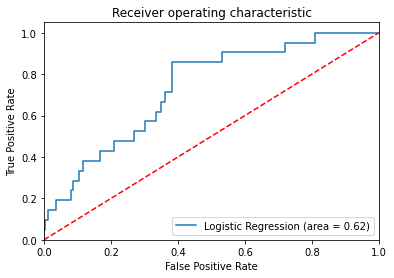

In [ ]:
logistic_regression(X__train__knn__boruta__smote, X__test__knn__boruta, target_var = 'STATUS')

###KNN BORUTA ROSE LOGREG

Accuracy of logistic regression classifier on test set: 0.75
              precision    recall  f1-score   support

          -1       0.95      0.76      0.85       293
           1       0.13      0.48      0.20        21

    accuracy                           0.75       314
   macro avg       0.54      0.62      0.52       314
weighted avg       0.90      0.75      0.81       314

Average Accuracy: 0.7452229299363057


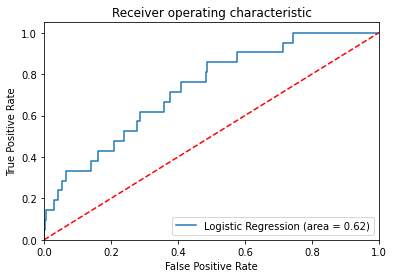

In [ ]:
logistic_regression(X__train__knn__boruta__rose, X__test__knn__boruta, target_var = 'STATUS')

###KNN RFE SMOTE LOGREG

Accuracy of logistic regression classifier on test set: 0.77
              precision    recall  f1-score   support

          -1       0.96      0.79      0.87       293
           1       0.15      0.52      0.24        21

    accuracy                           0.77       314
   macro avg       0.56      0.66      0.55       314
weighted avg       0.90      0.77      0.83       314

Average Accuracy: 0.7738853503184714


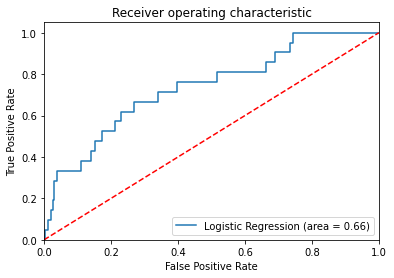

In [ ]:
logistic_regression(X__train__knn__rfe__smote, X__test__knn__rfe, target_var = 'STATUS')

###KNN RFE ROSE LOGREG

Accuracy of logistic regression classifier on test set: 0.78
              precision    recall  f1-score   support

          -1       0.97      0.79      0.87       293
           1       0.17      0.62      0.27        21

    accuracy                           0.78       314
   macro avg       0.57      0.70      0.57       314
weighted avg       0.91      0.78      0.83       314

Average Accuracy: 0.7770700636942676


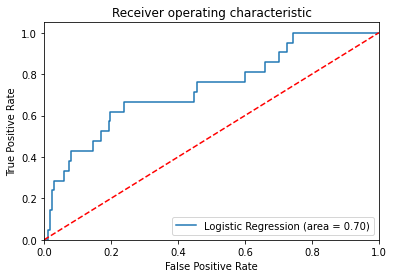

In [ ]:
logistic_regression(X__train__knn__rfe__rose, X__test__knn__rfe, target_var = 'STATUS')

###MICE BORUTA SMOTE LOGREG

Accuracy of logistic regression classifier on test set: 0.70
              precision    recall  f1-score   support

          -1       0.94      0.73      0.82       293
           1       0.09      0.38      0.15        21

    accuracy                           0.70       314
   macro avg       0.52      0.55      0.48       314
weighted avg       0.89      0.70      0.78       314

Average Accuracy: 0.7038216560509554


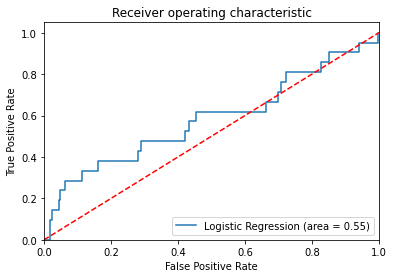

In [ ]:
logistic_regression(X__train__mice__boruta__smote, X__test__mice__boruta, target_var = 'STATUS')

###MICE BORUTA ROSE LOGREG

Accuracy of logistic regression classifier on test set: 0.71
              precision    recall  f1-score   support

          -1       0.95      0.73      0.83       293
           1       0.10      0.43      0.17        21

    accuracy                           0.71       314
   macro avg       0.53      0.58      0.50       314
weighted avg       0.89      0.71      0.78       314

Average Accuracy: 0.7133757961783439


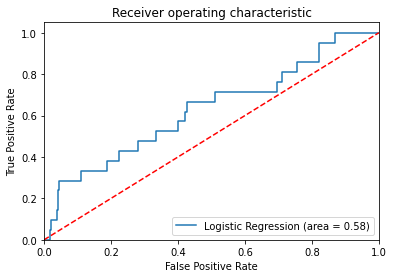

In [ ]:
logistic_regression(X__train__mice__boruta__rose, X__test__mice__boruta, target_var = 'STATUS')

###MICE RFE SMOTE LOGREG

Accuracy of logistic regression classifier on test set: 0.79
              precision    recall  f1-score   support

          -1       0.96      0.81      0.88       293
           1       0.15      0.48      0.23        21

    accuracy                           0.79       314
   macro avg       0.55      0.64      0.56       314
weighted avg       0.90      0.79      0.84       314

Average Accuracy: 0.7898089171974523


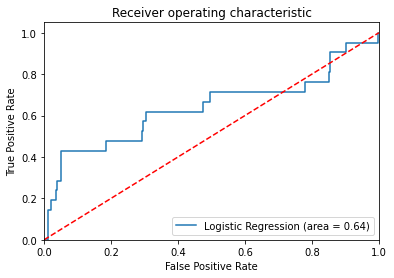

In [ ]:
logistic_regression(X__train__mice__rfe__smote, X__test__mice__rfe , target_var = 'STATUS')

###MICE RFE ROSE LOGREG

Accuracy of logistic regression classifier on test set: 0.77
              precision    recall  f1-score   support

          -1       0.95      0.80      0.87       293
           1       0.13      0.43      0.20        21

    accuracy                           0.77       314
   macro avg       0.54      0.61      0.53       314
weighted avg       0.90      0.77      0.82       314

Average Accuracy: 0.7707006369426752


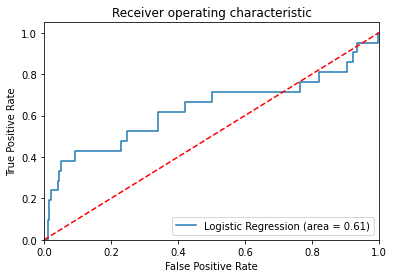

In [ ]:
logistic_regression(X__train__mice__rfe__rose, X__test__mice__rfe , target_var = 'STATUS')